In [3]:
import numpy as np

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import time
import math
import os
import gzip

from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

# functions to calculate WAMP, VWAP, etc. and display plots
from functions.market.features import *
from functions.market.plots import *
from functions.preprocessing import *
from functions.evaluation import *

In [4]:
np.random.seed(1234)
# set_random_seed(1234)
np.set_printoptions(precision=2)

# Dataprep

In [5]:
n_labels = 3

if n_labels == 2:
    class_names = [-1, 1]
elif n_labels == 3:
    class_names = [-1, 0, 1]
else:
    class_names = []

In [57]:
with gzip.GzipFile("data/kraken/eth_eur_d30_w100_l3.npy.gz", "r") as file:
    dataset = np.load(file)
    
lob_depth = int(len(dataset["snapshot"][0])/2)

print("Dataset size:", len(dataset))
print("Depth:", lob_depth)

Dataset size: 42668
Depth: 30


In [58]:
print("Label distribution in the whole dataset:")
count_labels(dataset)

Label distribution in the whole dataset:
UP labels: 15100 	 35.389519077528824%
NO_MOVE labels: 14332 	 33.58957532577107%
DOWN labels: 13236 	 31.020905596700104%


In [ ]:
window_size = 3*1440 # 1 day

input_ = dataset["snapshot"].reshape(-1, 3*lob_depth*2)

for i in range(len(input_)-window_size):
    scaler = StandardScaler().fit(input_[i:i+window_size+1])
    
    input_[i+window_size] = scaler.transform([input_[i+window_size]])[0]

dataset["snapshot"] = input_.reshape(-1, lob_depth*2, 3)
dataset = dataset[window_size:]

In [59]:
window_size = 300

for i in range(len(dataset["snapshot"])-window_size):
    price_scaler = StandardScaler().fit(dataset["snapshot"][i:i+window_size+1,:,0])
    volume_scaler = StandardScaler().fit(dataset["snapshot"][i:i+window_size+1,:,1])
    
    dataset["snapshot"][i+window_size,:,0] = price_scaler.transform([dataset["snapshot"][i+window_size,:,0]])[0]
    dataset["snapshot"][i+window_size,:,1] = volume_scaler.transform([dataset["snapshot"][i+window_size,:,1]])[0]
    
dataset = dataset[window_size:]

In [60]:
# sort labels for the equalization
ups = dataset[np.where(dataset["label"] == 1)]
nomoves = dataset[np.where(dataset["label"] == 0)]
downs = dataset[np.where(dataset["label"] == -1)]

# to equalize number of labels in the dataset use the lowest number
n_samples_per_label = np.min([len(ups), len(nomoves), len(downs)])

In [61]:
# train-test split
test_split = 0.2

ups_train, ups_test         = train_test_split(ups, test_size=test_split, random_state=42, shuffle = False, stratify = None)
nomoves_train, nomoves_test = train_test_split(nomoves, test_size=test_split, random_state=42, shuffle = False, stratify = None)
downs_train, downs_test     = train_test_split(downs, test_size=test_split, random_state=42, shuffle = False, stratify = None)

In [62]:
# shuffle before selecting by the n_samples_per_label 
# (to avoid not using any data from the last section of the bigger sets)
np.random.shuffle(ups_train)
np.random.shuffle(ups_test)

np.random.shuffle(nomoves_train)
np.random.shuffle(nomoves_test)

np.random.shuffle(downs_train)
np.random.shuffle(downs_test)

In [63]:
# create the mixed train and test sets
train = np.concatenate(
     (ups_train[:int(n_samples_per_label*(1-test_split))], 
     nomoves_train[:int(n_samples_per_label*(1-test_split))], 
     downs_train[:int(n_samples_per_label*(1-test_split))])
)

test = np.concatenate(
     (ups_test[:int(n_samples_per_label*(test_split))], 
     nomoves_test[:int(n_samples_per_label*(test_split))], 
     downs_test[:int(n_samples_per_label*(test_split))])
)

In [64]:
# shuffle to mix labels
np.random.shuffle(train)
np.random.shuffle(test)

In [65]:
# input
X_train = train['snapshot'][:,:,0:2]
X_test = test['snapshot'][:,:,0:2]

# reshape (flatten)
X_train = X_train.reshape(-1, 2*lob_depth*2)
X_test = X_test.reshape(-1, 2*lob_depth*2)

# output
Y_train = train['label']
Y_test = test['label']

In [66]:
print("Train shape:", X_train.shape)
print("Label distribution in train set:")
count_labels(train)

print()

print("Test shape:", X_test.shape)
print("Label distribution in test set:")
count_labels(test)

Train shape: (31620, 120)
Label distribution in train set:
UP labels: 10540 	 33.33333333333333%
NO_MOVE labels: 10540 	 33.33333333333333%
DOWN labels: 10540 	 33.33333333333333%

Test shape: (7905, 120)
Label distribution in test set:
UP labels: 2635 	 33.33333333333333%
NO_MOVE labels: 2635 	 33.33333333333333%
DOWN labels: 2635 	 33.33333333333333%


# Logistic Regression

In [67]:
C = 1e-3

if n_labels == 2:
    logreg = linear_model.LogisticRegression(C=C,solver='lbfgs')
else:
    logreg = linear_model.LogisticRegression(C=C,solver='saga', multi_class='multinomial', max_iter=10000, n_jobs=-1)

LOGISTIC REGRESSION

accuracy: 0.3738140417457306 %
precision: 0.37002790701948185 %
recall: 0.3738140417457306 %
f1_score: 0.37088726155480783 %

Confusion matrix, without normalization


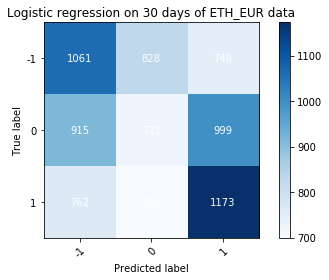

Normalized confusion matrix


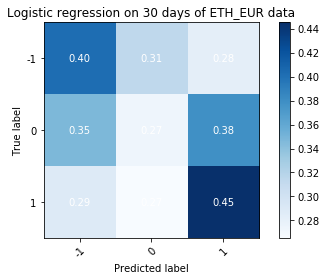

In [68]:
print("LOGISTIC REGRESSION")
logreg.fit(X_train,Y_train)

predictions = logreg.predict(X_test)

print()
metrics = evaluate_result(Y_test, predictions)
for key in metrics:
    print(key + ":", metrics[key], '%')
print()

title = 'Logistic regression on 30 days of ETH_EUR data'

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, normalize=True, title=title)

# Random Forest

In [69]:
# Create a Gaussian Classifier
clf = RandomForestClassifier(n_estimators = 128, random_state = 42)

RANDOM FOREST REGRESSION

accuracy: 0.4168247944339026 %
precision: 0.4136214804707003 %
recall: 0.4168247944339026 %
f1_score: 0.41249561068522805 %

Confusion matrix, without normalization


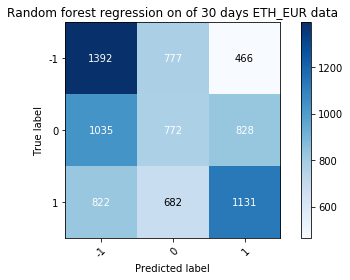

Normalized confusion matrix


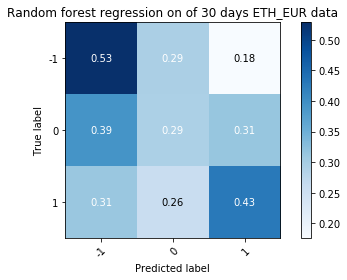

In [70]:
print("RANDOM FOREST REGRESSION")
clf.fit(X_train,Y_train)

predictions = clf.predict(X_test)

print()
metrics = evaluate_result(Y_test, predictions)
for key in metrics:
    print(key + ":", metrics[key], '%')
print()

title = 'Random forest regression on of 30 days ETH_EUR data'

# Plot non-normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(Y_test, predictions, classes=class_names, normalize=True, title=title)

# Predict based on history

In [ ]:
history_len = 40
alpha = 0.7

predictions = np.zeros([len(dataset)-history_len], dtype=[("label", int, 1)])

print("BASELINE PREDICTION BASED ON HISTORICAL MEAN", "\n")

# make predictions
for i in range(len(dataset)-history_len):
    mean = np.mean(dataset["wamp"][i:i+history_len])
    act_wamp = dataset["wamp"][i+history_len]
    volatility = calc_volatility(dataset["wamp"][i:i+history_len])
    
    threshold = volatility * alpha
    
    if n_labels == 2:
        if mean < act_wamp:
            predictions[i] = 1
        else:
            predictions[i] = -1
    
    elif n_labels == 3:
        if mean - act_wamp < -threshold:
            predictions[i] = 1
        elif mean - act_wamp > threshold:
            predictions[i] = -1
        else:
            predictions[i] = 0
    else:
        raise AttributeError()

metrics = evaluate_result(dataset["label"][history_len:], predictions["label"])
for key in metrics:
    print(key + ":", metrics[key], '%')
print()
        
title = "Baseline prediction on 30 days of ETH_EUR data"      


# Plot non-normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], classes=class_names,
                      title=title)

# Plot normalized confusion matrix
plot_confusion_matrix(dataset["label"][history_len:], predictions["label"], classes=class_names, normalize=True,
                      title=title)